# Plot matched NA and LN responses to different natural song segments

To select which songs to present in ideal imaging experiments.

In [1]:
%matplotlib inline
import editdistance
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from scipy import signal
from scipy.ndimage import gaussian_filter1d as smooth

from aux import zscore, get_seg
from disp import set_plot, plot_b, get_line

from record import smlt_ppln_ma, smlt_ppln_lnrelu

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

In [2]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

Load natural song snippets

In [3]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [4]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [5]:
from aux import get_seg
# get snippets
nt = int(round(60*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sng_s_long= 1*np.ones(len(t))
sng_p_long= 2*np.ones(len(t))

sng_s = np.zeros(len(t))

sng_s[t < 10] = 1
sng_s[(20 <= t) & (t < 30)] = 1
sng_s[(40 <= t) & (t < 50)] = 1

sng_p = np.zeros(len(t))

sng_p[t < 10] = 2
sng_p[(20 <= t) & (t < 30)] = 2
sng_p[(40 <= t) & (t < 50)] = 2

sngs_all = [sng_s_long, sng_p_long, sng_s, sng_p]  # song snippets


for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs_all.extend(segs)
    
sngs_all = np.array(sngs_all)

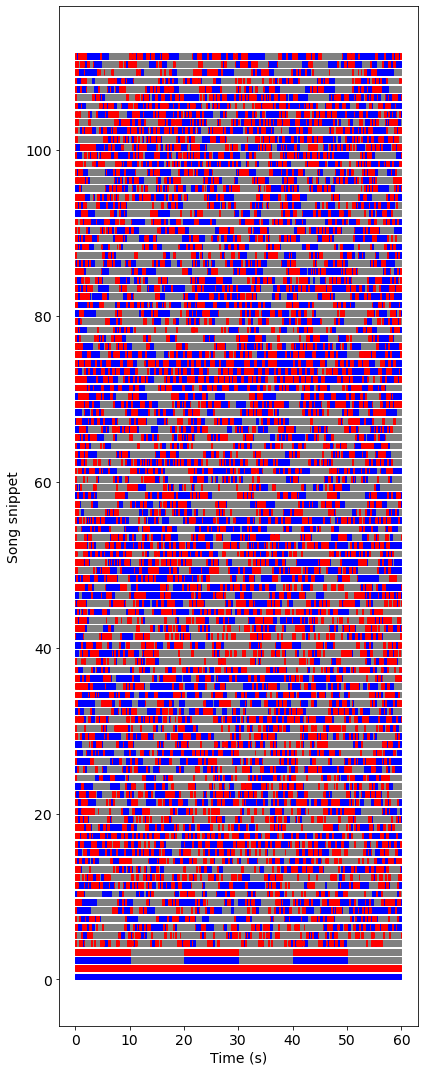

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs_all[:400]):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])
    
set_plot(ax, x_label='Time (s)', y_label='Song snippet', font_size=14)

### Simulate responses of matched MA/LN neuron pairs to different song segments

In [7]:
def ma_to_h_ln(tau_r, tau_a, x_s, x_p, dt):
    """Given a set of MA params, get LN filters that match MA step response."""
    th = np.arange(0, np.min([5*np.max([tau_r, tau_a]), 800]), dt)  # filter time vec
    gam = (1/tau_a) - (1/tau_r)
    
    if np.abs(gam) > 1e-8:
        r_step_s = x_s/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
        r_step_p = x_p/(gam*tau_r) * np.exp(-th/tau_a) * (np.exp(gam*th) - 1)
    else:
        r_step_s = x_s/tau_r * np.exp(-th/tau_a) * th
        r_step_p = x_p/tau_r * np.exp(-th/tau_a) * th
        
    h_s = np.gradient(r_step_s, dt)
    h_p = np.gradient(r_step_p, dt)
    
    return h_s, h_p, th

In [8]:
TAU_R_TAU_A_X_S_X_P = np.array([
    [2, 2, .5, .5],
    [10, 2, .5, .5],
    [30, 2, .5, .5],
])

nsng = 60

rs_ma_all = []
rs_ln_all = []

for tau_r, tau_a, x_s, x_p in TAU_R_TAU_A_X_S_X_P:
    # get ln filter params
    h_s, h_p, th = ma_to_h_ln(tau_r, tau_a, x_s, x_p, DT)
    
    rs_ma = np.nan*np.zeros((nsng, len(t)))
    rs_ln = np.nan*np.zeros((nsng, len(t)))
    
    for csng, sng in enumerate(sngs_all[:nsng]):
        i_s = (sng == 1).astype(float)
        i_p = (sng == 2).astype(float)
        
        r_ma = smlt_ppln_ma(i_s, i_p, np.array([tau_r]), tau_a, x_s, x_p, DT)[:, 0]
        r_ln = smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], DT, sign=1)[:, 0]
        
        r_ma /= np.nanstd(r_ma)
        r_ln /= np.nanstd(r_ln)
        
        rs_ma[csng] = r_ma
        rs_ln[csng] = r_ln
        
    rs_ma_all.append(rs_ma)
    rs_ln_all.append(rs_ln)

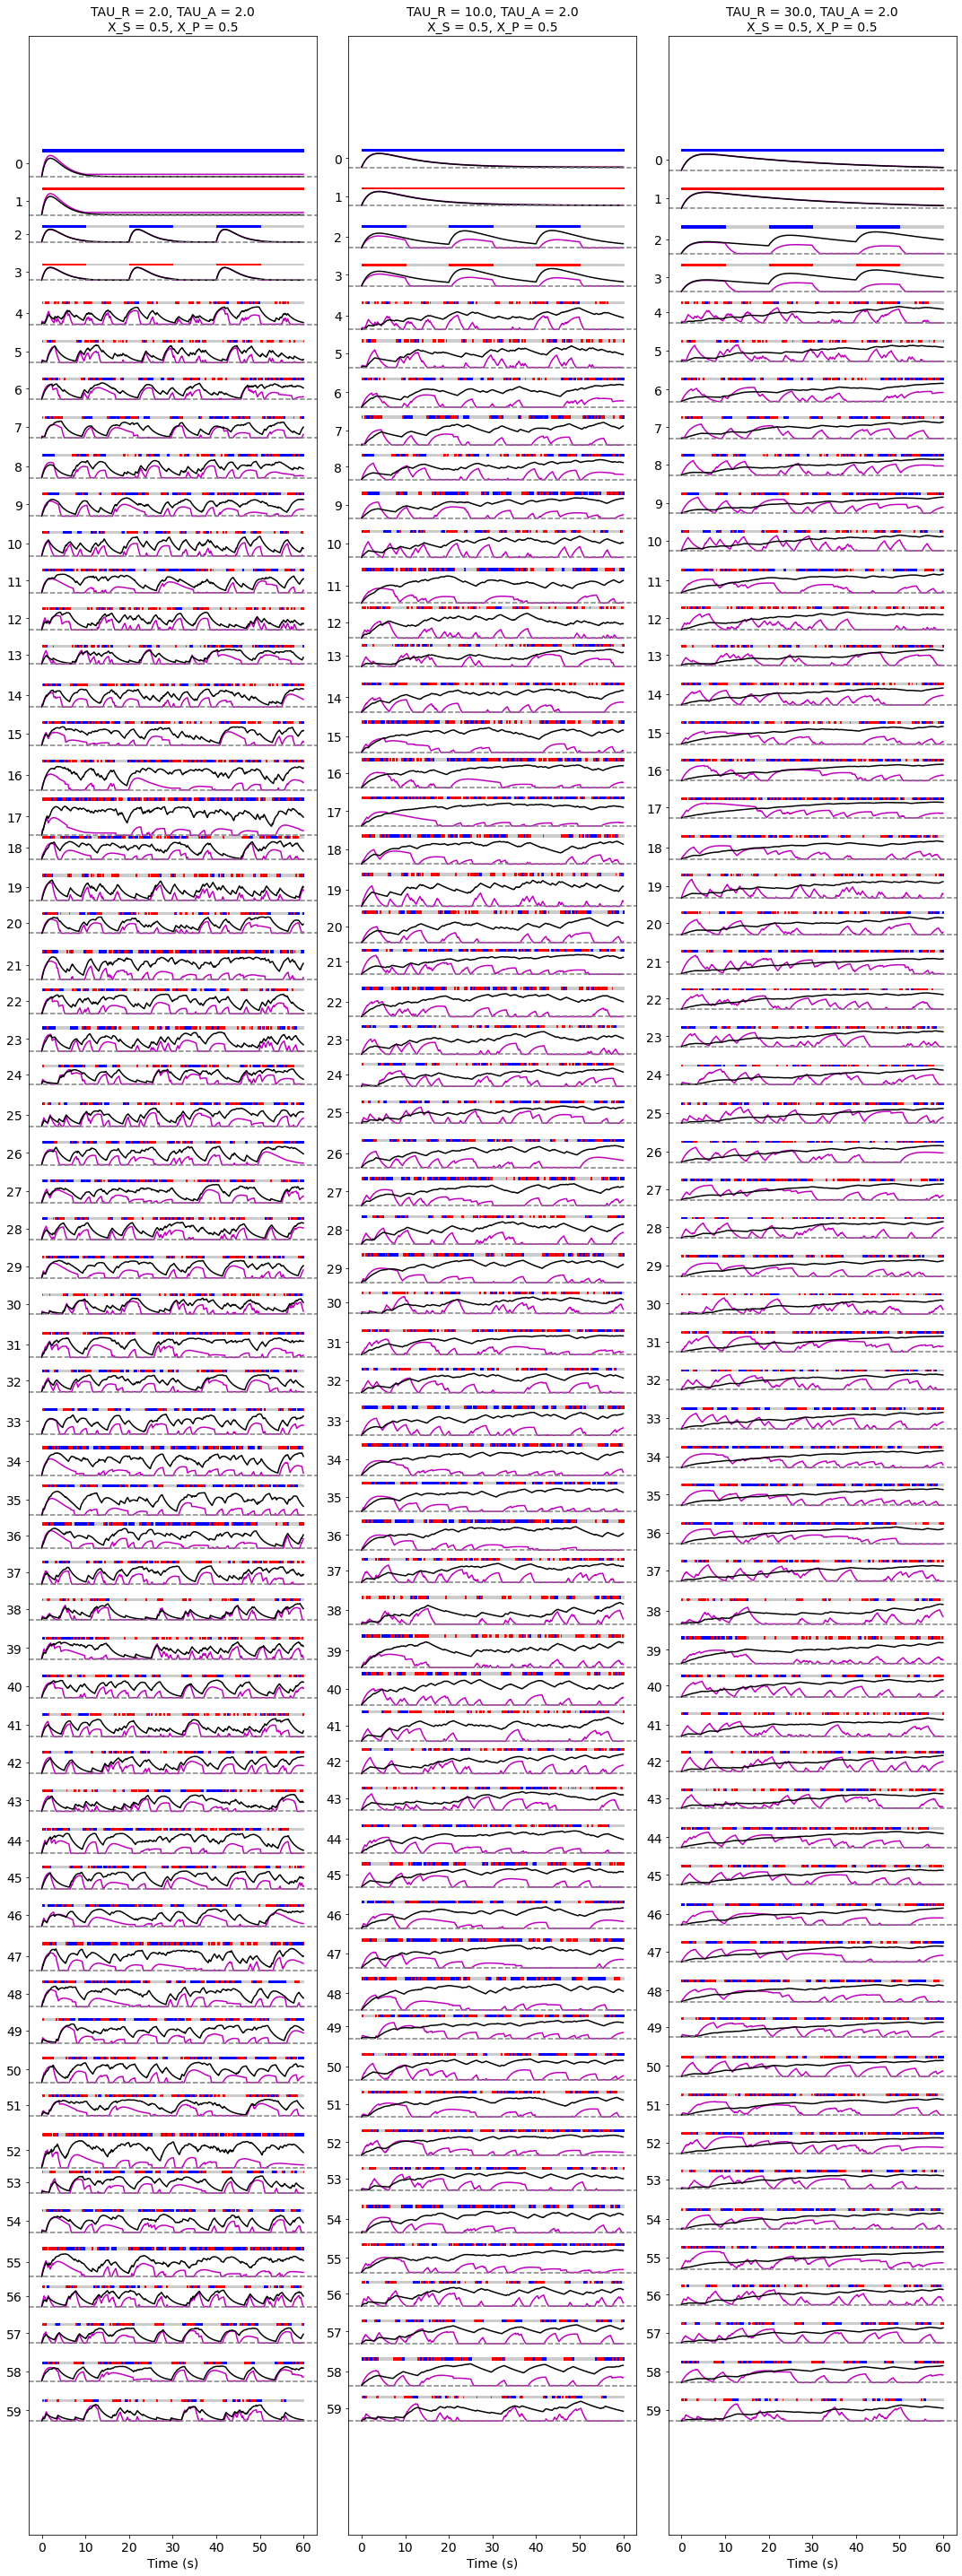

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 40), tight_layout=True, sharex=True)
        
for ax, rs_ma, rs_ln, (tau_r, tau_a, x_s, x_p) in zip(axs, rs_ma_all, rs_ln_all, TAU_R_TAU_A_X_S_X_P):
        
    y_offset = 0
    y_ticks = []
    for csng, (sng, r_ma, r_ln) in enumerate(zip(sngs_all, rs_ma, rs_ln)):
        
        lb = np.nanmin(cc([r_ln, r_ma]))
        ub = np.nanmax(cc([r_ln, r_ma]))
        
        y_wdw = 1.3*(ub-lb)
        
        ax.plot(t, r_ln - y_wdw + lb + y_offset, c='m')
        ax.plot(t, r_ma - y_wdw + lb + y_offset, c='k')
        ax.axhline(-y_wdw + lb + y_offset, c='gray', ls='--')
        
        extent = [t[0], t[-1]+DT, y_offset-(.1/1.3*y_wdw), y_offset]
        plot_b(ax, t, sng, c=[(.8, .8, .8), 'b', 'r'], extent=extent)
        
        y_tick = y_offset - .5*y_wdw
        
        y_ticks.append(y_tick)
        
        y_offset -= 9  #(1.4*y_wdw)
        
    set_plot(
        ax, x_label='Time (s)', y_ticks=y_ticks, y_tick_labels=np.arange(len(y_ticks)),
        title=f'TAU_R = {tau_r}, TAU_A = {tau_a}\nX_S = {x_s}, X_P = {x_p}',
        font_size=14)

In [10]:
TAU_R_TAU_A_X_S_X_P = np.array([
    [2, 60, .5, .5],
    [10, 60, .5, .5],
    [30, 60, .5, .5],
])

nsng = 60

rs_ma_all = []
rs_ln_all = []

for tau_r, tau_a, x_s, x_p in TAU_R_TAU_A_X_S_X_P:
    # get ln filter params
    h_s, h_p, th = ma_to_h_ln(tau_r, tau_a, x_s, x_p, DT)
    
    rs_ma = np.nan*np.zeros((nsng, len(t)))
    rs_ln = np.nan*np.zeros((nsng, len(t)))
    
    for csng, sng in enumerate(sngs_all[:nsng]):
        i_s = (sng == 1).astype(float)
        i_p = (sng == 2).astype(float)
        
        r_ma = smlt_ppln_ma(i_s, i_p, np.array([tau_r]), tau_a, x_s, x_p, DT)[:, 0]
        r_ln = smlt_ppln_lnrelu(i_s, i_p, h_s[:, None], h_p[:, None], DT, sign=1)[:, 0]
        
        r_ma /= np.nanstd(r_ma)
        r_ln /= np.nanstd(r_ln)
        
        rs_ma[csng] = r_ma
        rs_ln[csng] = r_ln
        
    rs_ma_all.append(rs_ma)
    rs_ln_all.append(rs_ln)

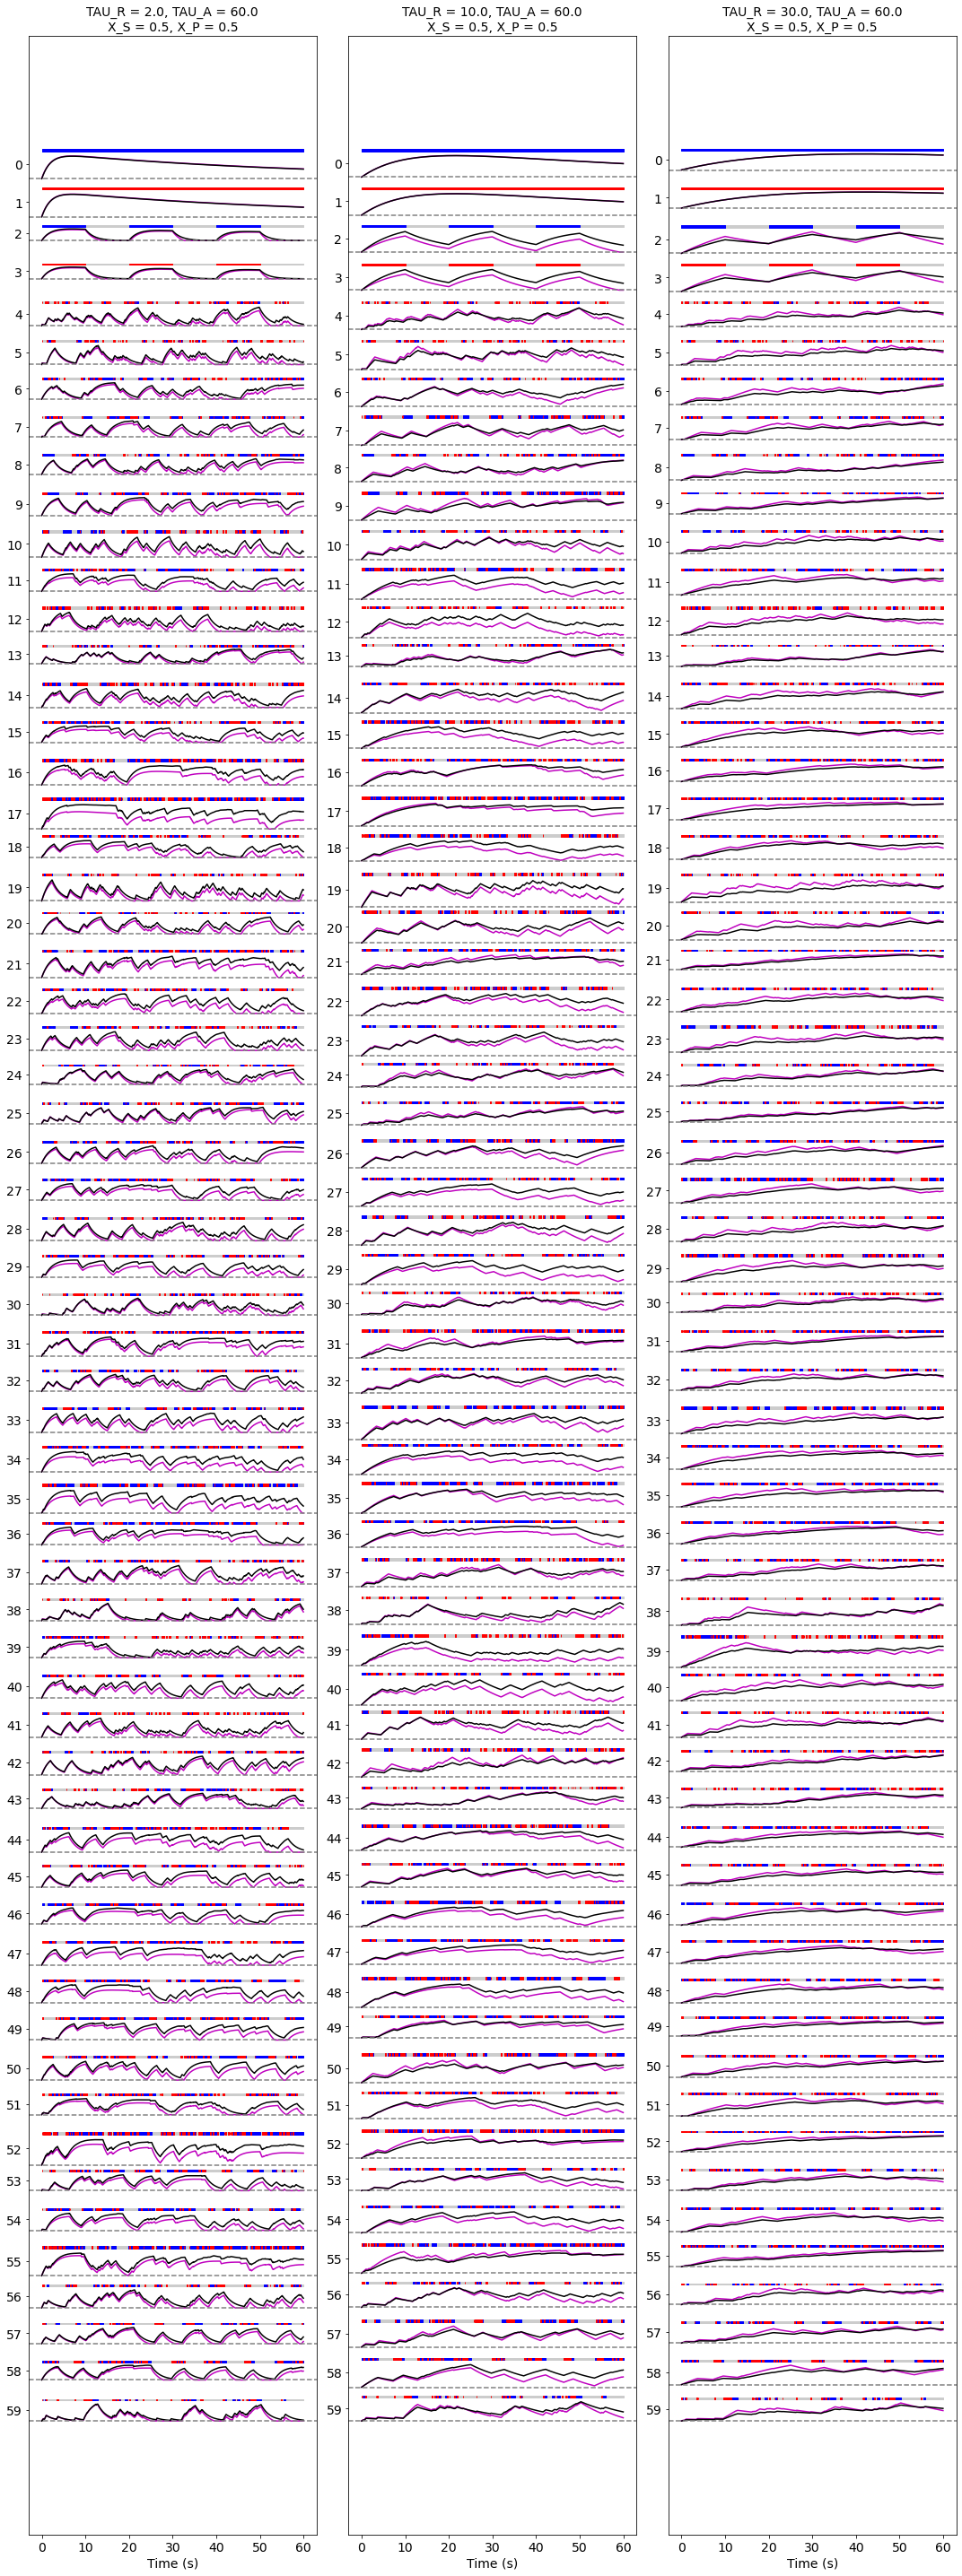

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 40), tight_layout=True, sharex=True)
        
for ax, rs_ma, rs_ln, (tau_r, tau_a, x_s, x_p) in zip(axs, rs_ma_all, rs_ln_all, TAU_R_TAU_A_X_S_X_P):
        
    y_offset = 0
    y_ticks = []
    for csng, (sng, r_ma, r_ln) in enumerate(zip(sngs_all, rs_ma, rs_ln)):
        
        lb = np.nanmin(cc([r_ln, r_ma]))
        ub = np.nanmax(cc([r_ln, r_ma]))
        
        y_wdw = 1.3*(ub-lb)
        
        ax.plot(t, r_ln - y_wdw + lb + y_offset, c='m')
        ax.plot(t, r_ma - y_wdw + lb + y_offset, c='k')
        ax.axhline(-y_wdw + lb + y_offset, c='gray', ls='--')
        
        extent = [t[0], t[-1]+DT, y_offset-(.1/1.3*y_wdw), y_offset]
        plot_b(ax, t, sng, c=[(.8, .8, .8), 'b', 'r'], extent=extent)
        
        y_tick = y_offset - .5*y_wdw
        
        y_ticks.append(y_tick)
        
        y_offset -= 9  #(1.4*y_wdw)
        
    set_plot(
        ax, x_label='Time (s)', y_ticks=y_ticks, y_tick_labels=np.arange(len(y_ticks)),
        title=f'TAU_R = {tau_r}, TAU_A = {tau_a}\nX_S = {x_s}, X_P = {x_p}',
        font_size=14)